In [ ]:
# Install wandb for saving training logs
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=d9af2f021c10a7827dfe124972a4f915e250e1e4f1d29ee5da6b603d6de3c281
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import os
import time
from tqdm import tqdm
import wandb
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, kernel_size=1, stride=1, padding=0),
            ConvBlock(64, 192, kernel_size=3, stride=1, padding=1),
        )

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(in_features=1024, out_features=num_classes)
        
        # Initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def forward(self, input):
        x = self.conv1(input)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.dropout(x)
        x = self.fc(x)
        
        x = F.log_softmax(x, dim=1)
        return x
    

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out1, out3red, out3, out5red, out5, out1pool):
        super(InceptionBlock, self).__init__()

        self.branch1 = ConvBlock(in_channels, out1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, out3red, kernel_size=1),
            ConvBlock(out3red, out3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, out5red, kernel_size=1),
            ConvBlock(out5red, out5, kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out1pool, kernel_size=1)
        )
        
    def forward(self, input):
        branch1 = self.branch1(input)
        branch2 = self.branch2(input)
        branch3 = self.branch3(input)
        branch4 = self.branch4(input)
    
        result = torch.cat((branch1, branch2, branch3, branch4), dim=1)
        return result
    
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
# Initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training parameters
epochs = 30
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 5*10e-4

# Declare the network
model = GoogLeNet(10).to(device)

# Loss function - Cross Entropy 
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer - Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# .MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)

In [ ]:
# Construct the dataset and data loader
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49, 0.48, 0.45), (0.25, 0.24, 0.26)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49, 0.48, 0.45), (0.25, 0.24, 0.26)),
    transforms.Resize((224, 224)),
])

train_data = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='.', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13736892.25it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
# Login to wandb
wandb.login()

# Initialize wandb
run = wandb.init(
    # set the wandb project where this run will be logged
    project="GoogLeNet-CIFAR10",
    
    # track hyperparameters and run metadata
    config={
        "architecture": "GoogLeNet",
        "dataset": "CIFAR10",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "momentum": "none",
        "with relu":"yes",
        "data-augmentation": "rhflip 0.5",
        "others": "dropout 0.4, scheduler 5, 0.1 gamma. batch norm weight init",
        "optimizer": "sgd",
        "softmax": "yes",
        "weight deacy":"yes",
    }
)

# Keep track of training and test loss
total_loss = [[], [], []]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: temitope-joloko. Use `wandb login --relogin` to force relogin


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = []

    for (images, labels) in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
    
    scheduler.step()
    epoch_loss = np.mean(running_loss)
    print(f'loss: {epoch_loss:.3f}')
    return epoch_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, correct_5 = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            
            # Calculate top-5 accuracy
            _, pred_5 = pred.topk(5)

            for i in range(len(labels)):
                if labels[i] in pred_5[i]:
                    correct_5 += 1

    
    test_loss /= num_batches
    correct /= size
    correct_5/=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Top-5 Accuracy: {(100*correct_5):>0.1f}%, \n Loss: {test_loss:>8f} \n")
    
    return test_loss, correct*100, correct_5*100

In [ ]:
print("Starting Training Loop...")
start_time = time.time()

for t in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    
    epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, top1_accuracy, top5_accuracy = test_loop(test_dataloader, model, loss_fn)
    
    total_loss[0].append(t+1)
    total_loss[1].append(epoch_loss)
    total_loss[2].append(test_loss)
    
    wandb.log({ "training_loss": epoch_loss, "test_loss": test_loss, "acc": top1_accuracy, "top5_accuracy": top5_accuracy })

    print("current lr", scheduler.get_last_lr())
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (t + 1, epochs, per_epoch_ptime))


print("Done!")
end_time = time.time()
total_ptime = end_time - start_time
print("Total time %.2f" % (total_ptime))

Starting Training Loop...
Epoch 1
-------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 782/782 [02:29<00:00,  5.22it/s]


loss: 1.433
Test Error: 
 Accuracy: 60.6%, Top-5 Accuracy: 96.2%, 
 Loss: 1.111807 

current lr [0.01]
Epoch 1 of 30 with 168.70 s
Epoch 2
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.51it/s]


loss: 0.919
Test Error: 
 Accuracy: 73.0%, Top-5 Accuracy: 98.0%, 
 Loss: 0.785417 

current lr [0.01]
Epoch 2 of 30 with 161.16 s
Epoch 3
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.52it/s]


loss: 0.688
Test Error: 
 Accuracy: 76.8%, Top-5 Accuracy: 98.6%, 
 Loss: 0.677298 

current lr [0.01]
Epoch 3 of 30 with 160.62 s
Epoch 4
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.605
Test Error: 
 Accuracy: 79.1%, Top-5 Accuracy: 98.6%, 
 Loss: 0.628081 

current lr [0.01]
Epoch 4 of 30 with 160.27 s
Epoch 5
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.581
Test Error: 
 Accuracy: 79.8%, Top-5 Accuracy: 98.8%, 
 Loss: 0.608084 

current lr [0.001]
Epoch 5 of 30 with 160.10 s
Epoch 6
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.371
Test Error: 
 Accuracy: 87.4%, Top-5 Accuracy: 99.5%, 
 Loss: 0.386161 

current lr [0.001]
Epoch 6 of 30 with 160.02 s
Epoch 7
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.295
Test Error: 
 Accuracy: 88.3%, Top-5 Accuracy: 99.6%, 
 Loss: 0.356539 

current lr [0.001]
Epoch 7 of 30 with 159.98 s
Epoch 8
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.263
Test Error: 
 Accuracy: 88.7%, Top-5 Accuracy: 99.6%, 
 Loss: 0.342914 

current lr [0.001]
Epoch 8 of 30 with 159.92 s
Epoch 9
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.232
Test Error: 
 Accuracy: 89.4%, Top-5 Accuracy: 99.6%, 
 Loss: 0.327814 

current lr [0.001]
Epoch 9 of 30 with 160.89 s
Epoch 10
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.51it/s]


loss: 0.211
Test Error: 
 Accuracy: 89.5%, Top-5 Accuracy: 99.7%, 
 Loss: 0.325204 

current lr [0.0001]
Epoch 10 of 30 with 162.09 s
Epoch 11
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.159
Test Error: 
 Accuracy: 90.6%, Top-5 Accuracy: 99.7%, 
 Loss: 0.295774 

current lr [0.0001]
Epoch 11 of 30 with 161.39 s
Epoch 12
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.49it/s]


loss: 0.144
Test Error: 
 Accuracy: 90.8%, Top-5 Accuracy: 99.7%, 
 Loss: 0.290795 

current lr [0.0001]
Epoch 12 of 30 with 161.48 s
Epoch 13
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.136
Test Error: 
 Accuracy: 90.8%, Top-5 Accuracy: 99.7%, 
 Loss: 0.287633 

current lr [0.0001]
Epoch 13 of 30 with 161.05 s
Epoch 14
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.129
Test Error: 
 Accuracy: 90.8%, Top-5 Accuracy: 99.8%, 
 Loss: 0.287995 

current lr [0.0001]
Epoch 14 of 30 with 161.33 s
Epoch 15
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.124
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.286291 

current lr [1e-05]
Epoch 15 of 30 with 161.53 s
Epoch 16
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.52it/s]


loss: 0.118
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.8%, 
 Loss: 0.286790 

current lr [1e-05]
Epoch 16 of 30 with 160.85 s
Epoch 17
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.116
Test Error: 
 Accuracy: 90.7%, Top-5 Accuracy: 99.8%, 
 Loss: 0.284856 

current lr [1e-05]
Epoch 17 of 30 with 161.03 s
Epoch 18
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.54it/s]


loss: 0.116
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.284701 

current lr [1e-05]
Epoch 18 of 30 with 160.22 s
Epoch 19
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.51it/s]


loss: 0.115
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.7%, 
 Loss: 0.285049 

current lr [1e-05]
Epoch 19 of 30 with 161.15 s
Epoch 20
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.51it/s]


loss: 0.116
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.286101 

current lr [1.0000000000000002e-06]
Epoch 20 of 30 with 161.07 s
Epoch 21
-------------------------------


100%|██████████| 782/782 [02:22<00:00,  5.50it/s]


loss: 0.114
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.7%, 
 Loss: 0.285202 

current lr [1.0000000000000002e-06]
Epoch 21 of 30 with 161.24 s
Epoch 22
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.54it/s]


loss: 0.116
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.285486 

current lr [1.0000000000000002e-06]
Epoch 22 of 30 with 160.30 s
Epoch 23
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.112
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.285398 

current lr [1.0000000000000002e-06]
Epoch 23 of 30 with 160.10 s
Epoch 24
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.53it/s]


loss: 0.115
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.283729 

current lr [1.0000000000000002e-06]
Epoch 24 of 30 with 160.09 s
Epoch 25
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.52it/s]


loss: 0.113
Test Error: 
 Accuracy: 90.8%, Top-5 Accuracy: 99.8%, 
 Loss: 0.285957 

current lr [1.0000000000000002e-07]
Epoch 25 of 30 with 160.13 s
Epoch 26
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.51it/s]


loss: 0.112
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.8%, 
 Loss: 0.284961 

current lr [1.0000000000000002e-07]
Epoch 26 of 30 with 160.42 s
Epoch 27
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.54it/s]


loss: 0.113
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.8%, 
 Loss: 0.286027 

current lr [1.0000000000000002e-07]
Epoch 27 of 30 with 159.74 s
Epoch 28
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.54it/s]


loss: 0.113
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.8%, 
 Loss: 0.283905 

current lr [1.0000000000000002e-07]
Epoch 28 of 30 with 160.13 s
Epoch 29
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.52it/s]


loss: 0.113
Test Error: 
 Accuracy: 90.8%, Top-5 Accuracy: 99.8%, 
 Loss: 0.284020 

current lr [1.0000000000000002e-07]
Epoch 29 of 30 with 160.57 s
Epoch 30
-------------------------------


100%|██████████| 782/782 [02:21<00:00,  5.52it/s]


loss: 0.114
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.8%, 
 Loss: 0.284897 

current lr [1.0000000000000004e-08]
Epoch 30 of 30 with 160.83 s
Done!
Total time 4828.42


In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.7%, 
 Loss: 0.286133 



(0.286133484191196, 90.86, 99.72999999999999)

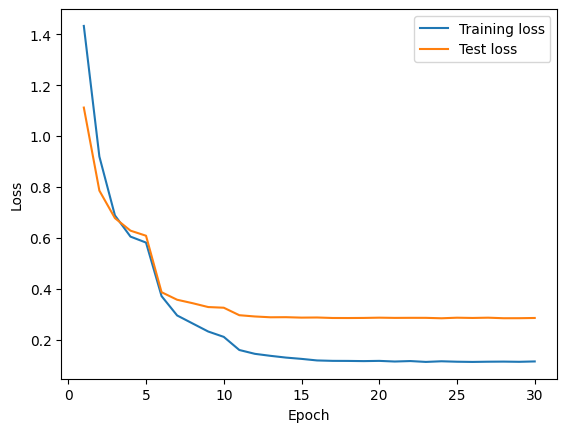

In [ ]:
plt.plot(total_loss[0], total_loss[1], label = "Training loss")
plt.plot(total_loss[0], total_loss[2], label = "Test loss")

# Add labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Close wandb run
run.finish()

In [ ]:
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}


size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct, correct_5 = 0, 0, 0

correct_idx = []
wrong_idx = []
with torch.no_grad():
    for batch, (images, labels) in enumerate(test_dataloader):
            print("Starting with batch", batch)
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            
            # Calculate top-5 accuracy
            _, pred_5 = pred.topk(5)

            for i in range(len(labels)):
              if labels[i] == pred_5[i][0]:
                if len(correct_idx) < 5:
                  correct_idx.append([(batch*64) + i, labels[i].item()])
              elif labels[i] != pred_5[i][0]:
                if len(wrong_idx) < 5:
                  wrong_idx.append([(batch*64) + i, labels[i].item(), pred_5[i]])

            break


Starting with batch 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
wrong_idx

[[47, 9, tensor([8, 9, 0, 1, 3], device='cuda:0')],
 [49, 6, tensor([4, 6, 0, 2, 3], device='cuda:0')],
 [58, 4, tensor([5, 3, 4, 7, 2], device='cuda:0')],
 [59, 6, tensor([2, 6, 3, 4, 5], device='cuda:0')],
 [61, 3, tensor([5, 3, 7, 4, 2], device='cuda:0')]]

In [ ]:
correct_idx

[[0, 3], [2, 8], [3, 0], [4, 6]]

In [ ]:
testd = datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())

sample_idx [0, 3]
sample_idx [2, 8]
sample_idx [3, 0]
sample_idx [4, 6]


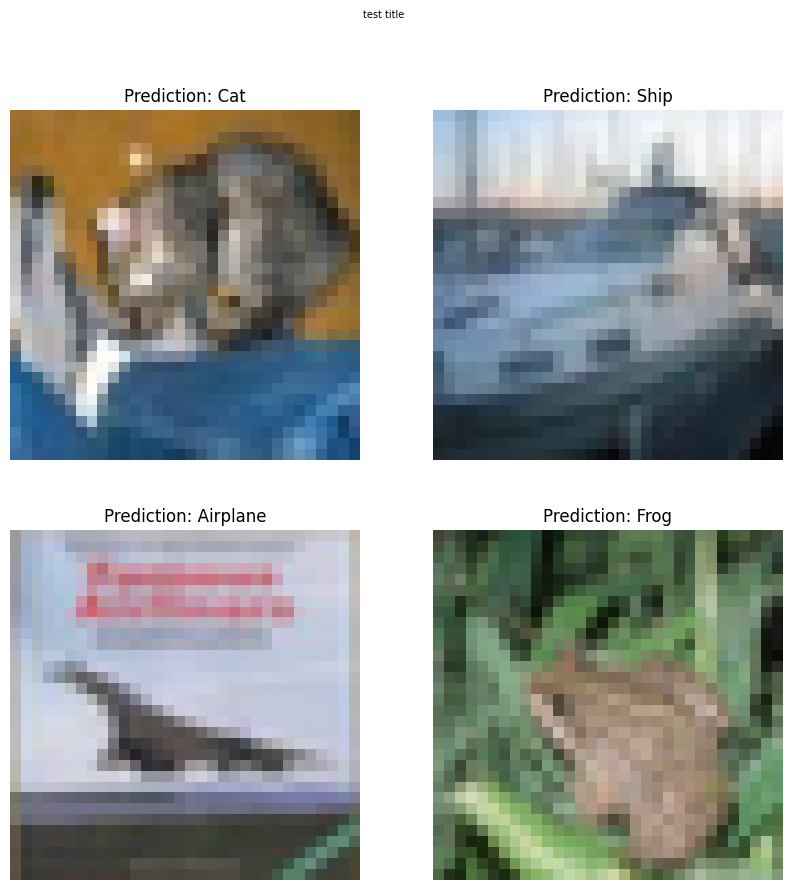

In [ ]:
figure = plt.figure(figsize=(10, 10))
figure.suptitle('test title', fontsize=7)
cols, rows = 2, 2

for i in range(1, cols * rows+1):
    sample_idx = correct_idx[i-1]
    print("sample_idx", sample_idx)
    img, label = testd[correct_idx[i-1][0]]
    img = img.permute(1,2,0).view(32,32,3)
    figure.add_subplot(rows, cols, i)
    ac = correct_idx[i-1][1]
    # pd = correct_idx[i-1][2].cpu().numpy()
    # pd_str = ""
    # for i in range(3):
    #    pd_str += labels_map[pd[i]]
    #    pd_str += " "
    plt.title("Prediction: {}".format(labels_map[ac]))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    # plt.imshow(img.squeeze(), cmap="gray")
plt.show()

[[0, 3], [2, 8], [3, 0], [4, 6]]

In [ ]:

}

array([5, 3, 4, 7, 2])